In [437]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [438]:
def get_unique_values_with_counts(dataframe, column_name):
    """
    This function returns a dictionary with unique values in a specified column of a dataframe
    and their corresponding counts.
    
    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    column_name (str): The name of the column to extract unique values and counts from.
    
    Returns:
    dict: A dictionary where keys are unique values and values are their counts.
    """
    value_counts = dataframe[column_name].value_counts()
    return value_counts.to_dict()

In [439]:
df = pd.read_csv("https://datasocibmproject.s3.ap-southeast-2.amazonaws.com/structured_data/capital_project_schedules_and_budgets_1.csv")
df = df.drop(df.columns[0], axis=1)

df.to_csv('ibm_data.csv', index=False)
# df

In [440]:
# Basic Data Inspection
# print("First few rows of the dataset:")
# df.head()

In [441]:
df.columns.tolist()

['project_geographic_district',
 'project_building_identifier',
 'project_school_name',
 'project_type',
 'project_description',
 'project_phase_name',
 'project_status_name',
 'project_phase_actual_start_date',
 'project_phase_planned_end_date',
 'project_phase_actual_end_date',
 'project_budget_amount',
 'final_estimate_of_actual_costs_through_end_of_phase_amount',
 'total_phase_actual_spending_amount',
 'dsf_number_s',
 'failure']

### Check distinct values in each column

In [442]:
# get_unique_values_with_counts(df, 'project_phase_planned_end_date')
# get_unique_values_with_counts(df, 'project_phase_name')
get_unique_values_with_counts(df, 'project_status_name')
# get_unique_values_with_counts(df, 'project_phase_actual_end_date')


{'PNS': 3046, 'Complete': 2981, 'In-Progress': 2158}

#### Handling Missing Values

In [443]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()
missing_values

project_geographic_district                                      0
project_building_identifier                                      0
project_school_name                                              0
project_type                                                     0
project_description                                              0
project_phase_name                                               1
project_status_name                                              0
project_phase_actual_start_date                                  0
project_phase_planned_end_date                                   0
project_phase_actual_end_date                                 2158
project_budget_amount                                            0
final_estimate_of_actual_costs_through_end_of_phase_amount       4
total_phase_actual_spending_amount                               0
dsf_number_s                                                     0
failure                                                       

In [444]:
# Filling missing values
df['project_phase_name'] = df['project_phase_name'].fillna('Unknown')
df['project_phase_actual_end_date'] = df['project_phase_actual_end_date'].fillna('Not Completed')

# Filling the missing values in 'final_estimate_of_actual_costs_through_end_of_phase_amount' with the median
median_costs = df['final_estimate_of_actual_costs_through_end_of_phase_amount'].median()
df['final_estimate_of_actual_costs_through_end_of_phase_amount'] = df['final_estimate_of_actual_costs_through_end_of_phase_amount'].fillna(median_costs)

# Verify if the missing values have been handled
missing_values_after = df.isnull().sum()
missing_values_after

project_geographic_district                                   0
project_building_identifier                                   0
project_school_name                                           0
project_type                                                  0
project_description                                           0
project_phase_name                                            0
project_status_name                                           0
project_phase_actual_start_date                               0
project_phase_planned_end_date                                0
project_phase_actual_end_date                                 0
project_budget_amount                                         0
final_estimate_of_actual_costs_through_end_of_phase_amount    0
total_phase_actual_spending_amount                            0
dsf_number_s                                                  0
failure                                                       0
dtype: int64

#### (No duplicates)

In [445]:
# Checking for duplicate rows
duplicate_rows = df.duplicated().sum()

# Removing duplicate rows if any
df_cleaned = df.drop_duplicates()

duplicate_rows, df_cleaned.shape

(0, (8185, 15))

In [446]:
# List of keywords to keep
project_types = [
    "SCA", "CIP", "DIIT", "DOE", "DOES", "DOER",
    "RESOA", "IEH", "PRE-K", "DCAS", "FY", "FAST TRACK PROJECTS"
]

# Function to find keywords in specified columns
def find_keywords(row, columns, keywords):
    found_keywords = []
    for column in columns:
        for keyword in keywords:
            if pd.notna(row[column]) and keyword in row[column]:
                found_keywords.append(keyword)
    return found_keywords

df = df.map(lambda x: x.replace('PREK', 'PRE-K') if isinstance(x, str) else x)

# Columns to check for project types
columns_to_check = ['project_type', 'project_phase_planned_end_date']

# Apply the function to each row
df['project_type_split'] = df.apply(lambda row: find_keywords(row, columns_to_check, project_types), axis=1)

# Explode the list into separate rows
df_exploded = df.explode('project_type_split')

# Filter out rows where 'project_type_split' is NaN
df_exploded = df_exploded[df_exploded['project_type_split'].notna()]
# df_exploded
get_unique_values_with_counts(df_exploded, 'project_type_split')

{'SCA': 6546,
 'CIP': 5457,
 'RESOA': 3573,
 'DOE': 1307,
 'IEH': 1304,
 'DIIT': 696,
 'DOES': 318,
 'DOER': 170,
 'PRE-K': 57,
 'DCAS': 10}

### Drop duplicates after splitting the project types

In [447]:
# Checking for duplicate rows
duplicate_rows = df_exploded.duplicated().sum()

# Removing duplicate rows if any
df_cleaned = df_exploded.drop_duplicates()

duplicate_rows, df_cleaned.shape

(1254, (18184, 16))

In [448]:
df_without_PNS = df_cleaned[~df_cleaned.apply(lambda row: row.astype(str).str.contains('PNS').any(), axis=1)]
df_without_PNS.reset_index(drop=True, inplace=True)

df_without_PNS.shape

(10153, 16)

#### Correcting data types

In [449]:
# get_unique_values_with_counts(df_without_PNS, 'project_phase_actual_start_date')

{'06/24/2013': 197,
 '05/15/2017': 134,
 '08/14/2017': 121,
 '05/08/2017': 94,
 '06/21/2017': 93,
 '06/19/2017': 93,
 '12/18/2017': 88,
 '05/16/2017': 80,
 '08/07/2017': 74,
 '06/07/2017': 72,
 '08/30/2017': 68,
 '06/28/2017': 67,
 '06/14/2017': 66,
 '09/06/2017': 64,
 '05/01/2017': 62,
 '09/07/2017': 60,
 '06/05/2017': 59,
 '07/24/2017': 57,
 '05/22/2017': 56,
 '04/10/2017': 55,
 '07/10/2017': 55,
 '05/11/2017': 54,
 '05/05/2017': 53,
 '08/22/2017': 50,
 '11/17/2017': 49,
 '06/15/2017': 48,
 '06/30/2017': 47,
 '01/19/2017': 47,
 '06/27/2017': 47,
 '12/01/2017': 47,
 '08/04/2017': 46,
 '06/26/2017': 44,
 '07/12/2017': 44,
 '04/24/2017': 44,
 '04/28/2017': 43,
 '08/09/2017': 43,
 '07/17/2017': 43,
 '09/11/2017': 43,
 '08/11/2017': 42,
 '07/05/2017': 42,
 '06/20/2017': 42,
 '05/19/2017': 42,
 '06/22/2017': 42,
 '02/03/2017': 41,
 '04/26/2017': 41,
 '02/06/2017': 41,
 '03/08/2017': 39,
 '11/30/2017': 38,
 '01/25/2017': 37,
 '08/31/2017': 37,
 '08/21/2017': 36,
 '06/23/2017': 36,
 '06/12/2

In [450]:
# Converting date columns to datetime format
df_cleaned['project_phase_actual_start_date'] = pd.to_datetime(df_cleaned['project_phase_actual_start_date'], errors='coerce')
df_cleaned['project_phase_planned_end_date'] = pd.to_datetime(df_cleaned['project_phase_planned_end_date'], errors='coerce')
df_cleaned['project_phase_actual_end_date'] = df_cleaned['project_phase_actual_end_date'].replace('Not Completed', pd.NaT)
df_cleaned['project_phase_actual_end_date'] = pd.to_datetime(df_cleaned['project_phase_actual_end_date'], errors='coerce')

# Converting numerical columns to appropriate types
df_cleaned['project_budget_amount'] = pd.to_numeric(df_cleaned['project_budget_amount'], errors='coerce')
df_cleaned['final_estimate_of_actual_costs_through_end_of_phase_amount'] = pd.to_numeric(df_cleaned['final_estimate_of_actual_costs_through_end_of_phase_amount'], errors='coerce')
df_cleaned['total_phase_actual_spending_amount'] = pd.to_numeric(df_cleaned['total_phase_actual_spending_amount'], errors='coerce')

# Standardizing text data (e.g., project descriptions and names)
df_cleaned['project_school_name'] = df_cleaned['project_school_name'].str.title()
df_cleaned['project_type'] = df_cleaned['project_type'].str.upper()
df_cleaned['project_description'] = df_cleaned['project_description'].str.capitalize()

# Verifying the changes
df_cleaned.dtypes

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_3877/1532190220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['project_phase_actual_start_date'] = pd.to_datetime(df_cleaned['project_phase_actual_start_date'], errors='coerce')
/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_3877/1532190220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['project_phase_planned_end_date'] = pd.to_datetime(df_cleaned['project_phase_planned_end_date'], errors='coerce')
/var/f

project_geographic_district                                            int64
project_building_identifier                                           object
project_school_name                                                   object
project_type                                                          object
project_description                                                   object
project_phase_name                                                    object
project_status_name                                                   object
project_phase_actual_start_date                               datetime64[ns]
project_phase_planned_end_date                                datetime64[ns]
project_phase_actual_end_date                                 datetime64[ns]
project_budget_amount                                                float64
final_estimate_of_actual_costs_through_end_of_phase_amount           float64
total_phase_actual_spending_amount                                   float64

In [451]:
get_unique_values_with_counts(df_cleaned, 'project_phase_planned_end_date')

{Timestamp('2018-01-15 00:00:00'): 518,
 Timestamp('2013-12-31 00:00:00'): 191,
 Timestamp('2017-07-19 00:00:00'): 73,
 Timestamp('2018-05-04 00:00:00'): 67,
 Timestamp('2018-01-25 00:00:00'): 67,
 Timestamp('2017-07-07 00:00:00'): 62,
 Timestamp('2017-07-21 00:00:00'): 53,
 Timestamp('2017-07-14 00:00:00'): 50,
 Timestamp('2017-07-05 00:00:00'): 48,
 Timestamp('2018-02-05 00:00:00'): 41,
 Timestamp('2017-11-16 00:00:00'): 39,
 Timestamp('2017-09-01 00:00:00'): 34,
 Timestamp('2018-02-01 00:00:00'): 32,
 Timestamp('2017-08-14 00:00:00'): 30,
 Timestamp('2017-08-21 00:00:00'): 28,
 Timestamp('2018-11-05 00:00:00'): 28,
 Timestamp('2018-12-17 00:00:00'): 28,
 Timestamp('2018-01-31 00:00:00'): 27,
 Timestamp('2017-07-17 00:00:00'): 27,
 Timestamp('2017-11-09 00:00:00'): 27,
 Timestamp('2017-09-25 00:00:00'): 26,
 Timestamp('2017-08-11 00:00:00'): 25,
 Timestamp('2017-08-15 00:00:00'): 25,
 Timestamp('2017-10-30 00:00:00'): 24,
 Timestamp('2017-08-16 00:00:00'): 24,
 Timestamp('2018-02-23 

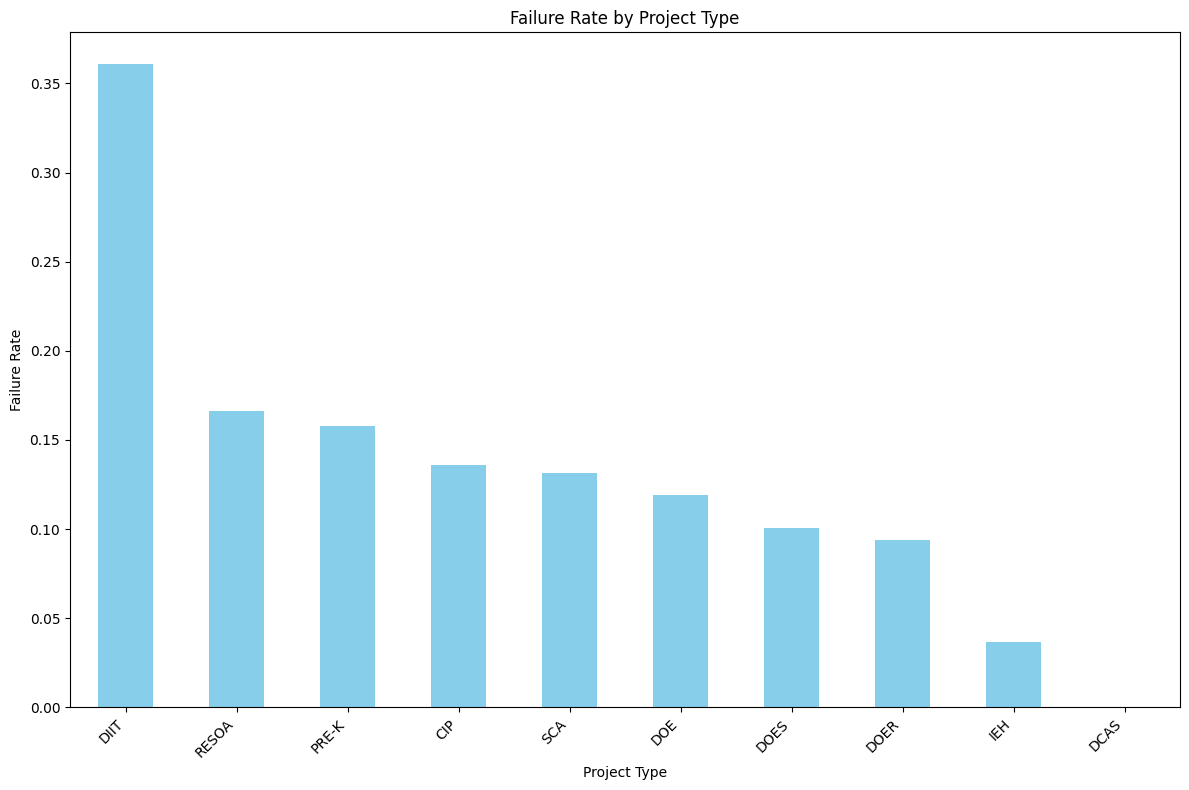

In [452]:
# Calculate the failure rate for each project type
failure_rate = df_exploded.groupby('project_type_split')['failure'].mean()

# Sort the failure rate
failure_rate = failure_rate.sort_values(ascending=False)

# Bar chart
plt.figure(figsize=(12, 8))
failure_rate.plot(kind='bar', color='skyblue')
plt.title('Failure Rate by Project Type')
plt.xlabel('Project Type')
plt.ylabel('Failure Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [453]:
# Download to csv
df_cleaned.to_csv("ibm_cleaned.csv", index=False)
pd.read_csv('ibm_cleaned.csv').head()

,project_geographic_district,project_building_identifier,project_school_name,project_type,project_description,project_phase_name,project_status_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount,dsf_number_s,failure,project_type_split
0,10,X254,I.S. 254 - Bronx,SCA CIP,Facade/roofs,Construction,In-Progress,2016-07-07,2018-03-28,NaN,4050000.0,4229193.0,3791127.0,"DSF: 0000821031, 0000822210",False,SCA
1,10,X254,I.S. 254 - Bronx,SCA CIP,Facade/roofs,Construction,In-Progress,2016-07-07,2018-03-28,NaN,4050000.0,4229193.0,3791127.0,"DSF: 0000821031, 0000822210",False,CIP
2,10,X254,I.S. 254 - Bronx,SCA CIP,Facade/roofs,"CM, F&E",In-Progress,2016-07-07,2018-03-28,NaN,252000.0,489326.0,485620.0,"DSF: 0000821031, 0000822210",False,SCA
3,10,X254,I.S. 254 - Bronx,SCA CIP,Facade/roofs,"CM, F&E",In-Progress,2016-07-07,2018-03-28,NaN,252000.0,489326.0,485620.0,"DSF: 0000821031, 0000822210",False,CIP
4,10,X254,I.S. 254 - Bronx,SCA CIP RESOA,Fy16 reso a ip surveillance camera installation,Scope,Complete,2017-07-27,2017-11-27,2017-08-03,0.0,1792.0,1792.0,DSF: 0000823560,False,SCA


#### Reformatting budget and spendings data format

I.e. format the budget and spending columns to use fixed-point notation with thousands separators

In [454]:
# # Function to format numbers with thousands separator
# def format_number(num):
#     return f"{num:,.2f}"

# # Apply formatting to the relevant columns
# df_cleaned['project_budget_amount'] = df_cleaned['project_budget_amount'].apply(format_number)
# df_cleaned['final_estimate_of_actual_costs_through_end_of_phase_amount'] = df_cleaned['final_estimate_of_actual_costs_through_end_of_phase_amount'].apply(format_number)
# df_cleaned['total_phase_actual_spending_amount'] = df_cleaned['total_phase_actual_spending_amount'].apply(format_number)

# # Display a sample of the DataFrame to verify the formatting
# df_cleaned[['project_budget_amount', 'final_estimate_of_actual_costs_through_end_of_phase_amount', 'total_phase_actual_spending_amount']].head()

#### Descriptive statistics

1.	Summary Statistics for Numeric Columns:

Mean, median, standard deviation, minimum, and maximum.

2.	Count of Unique Values for Categorical Columns:

Unique values and their counts for columns such as project_geographic_district, project_building_identifier, project_school_name, project_type, project_phase_name, project_status_name.

In [455]:
# Display summary statistics for numeric columns
df_cleaned.describe()

,project_geographic_district,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,project_budget_amount,final_estimate_of_actual_costs_through_end_of_phase_amount,total_phase_actual_spending_amount
count,18184.000000,10153,7526,5983,1.573700e+04,1.818400e+04,1.818400e+04
mean,17.608777,2016-07-19 17:41:18.833842176,2016-12-20 21:34:12.086101504,2016-10-04 23:32:48.176500224,9.591021e+05,8.180000e+05,2.712237e+05
min,1.000000,2003-09-12 00:00:00,2003-09-12 00:00:00,2003-09-12 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000,2016-01-28 00:00:00,2016-04-22 18:00:00,2016-03-30 00:00:00,1.200000e+04,1.450800e+04,0.000000e+00
50%,19.000000,2017-03-21 00:00:00,2017-07-21 00:00:00,2017-07-01 00:00:00,6.791000e+04,6.294000e+04,3.985000e+03
75%,26.000000,2017-07-12 00:00:00,2018-01-15 00:00:00,2017-09-08 00:00:00,2.679130e+05,2.200000e+05,5.512350e+04
max,32.000000,2017-12-28 00:00:00,2022-08-12 00:00:00,2017-12-31 00:00:00,1.108760e+08,1.150066e+08,7.934706e+07
std,9.481379,NaN,NaN,NaN,5.123456e+06,4.615308e+06,2.382114e+06


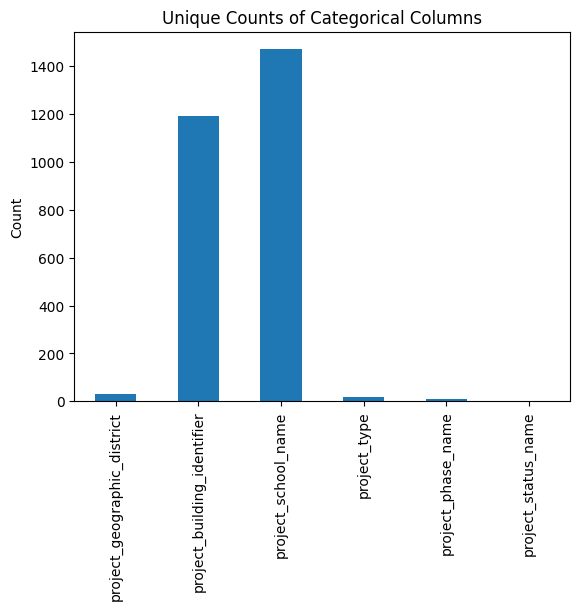

1196 distinct values in project_building_identifier
1483 distinct values in project_school_name
20 distinct values in project_type
1363 distinct values in project_description
9 distinct values in project_phase_name
3 distinct values in project_status_name
3554 distinct values in dsf_number_s


TypeError: unhashable type: 'list'

In [456]:
# Count unique values for categorical columns
categorical_summary = df_cleaned[[
    'project_geographic_district', 
    'project_building_identifier', 
    'project_school_name', 
    # 'project_description',
    'project_type', 
    'project_phase_name', 
    'project_status_name'
]].nunique()

# Visualization: Example of a bar plot for unique counts of categorical columns
categorical_summary.plot(kind='bar')
plt.title('Unique Counts of Categorical Columns')
plt.ylabel('Count')
plt.show()

categorical_features = df_cleaned.select_dtypes(include=[object]).columns

for col in categorical_features:
    unique_values = df[col].unique()
    num_values = len(unique_values)
    print(f'{num_values} distinct values in {col}')

In [ ]:
# # Distribution of Numerical Features
# numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns

# for feature in numerical_features:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df_cleaned[feature], kde=True, bins=30)
#     plt.title(f'Distribution of {feature}')
#     plt.show()


#### Distribution of Project Budget Amounts

In [ ]:
max_value = df_cleaned['project_budget_amount'].max()
max_value

110876040.0

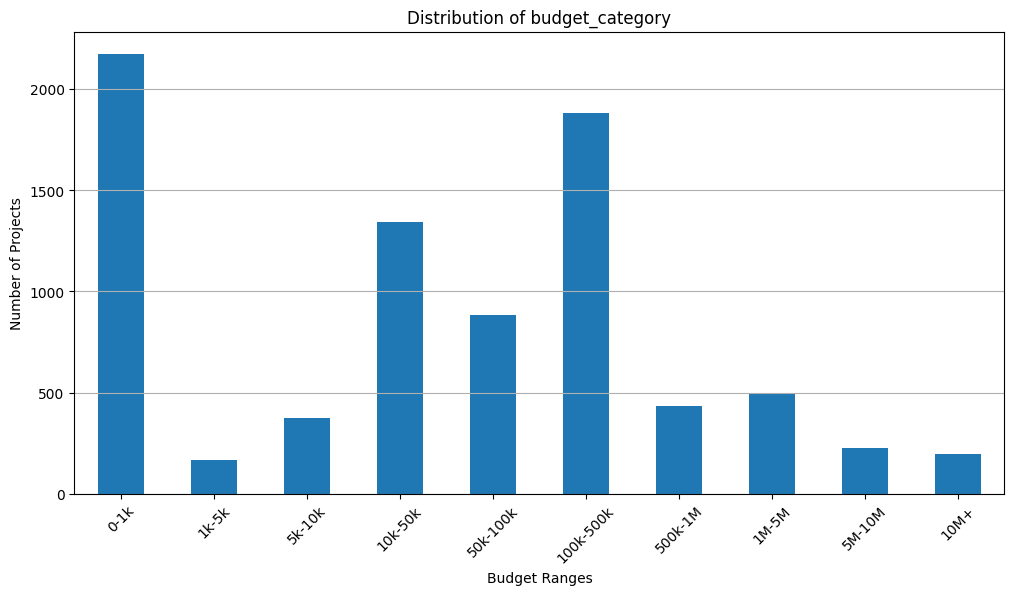

In [ ]:
# Replace NaNs with 0s
df_cleaned['project_budget_amount'] = df_cleaned['project_budget_amount'].fillna(0)

# Define budget bins
bins = [0, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, max_value]
labels = ['0-1k', '1k-5k', '5k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1M', '1M-5M', '5M-10M', '10M+']

# Categorize budget into bins
df_cleaned['budget_category'] = pd.cut(
    df_cleaned['project_budget_amount'], bins=bins, labels=labels, right=False
)

# Count the number of budgets in each category
budget_counts = df_cleaned['budget_category'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(12, 6))
budget_counts.plot(kind='bar')
plt.xlabel('Budget Ranges')
plt.ylabel('Number of Projects')
plt.title('Distribution of budget_category')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Seaborn version
# plt.figure(figsize=(10, 6))
# sns.histplot(df_cleaned['budget_category'], kde=True, bins=30)
# plt.title(f'Distribution of budget_category')
# plt.show()

#### Project Count by Geographic District


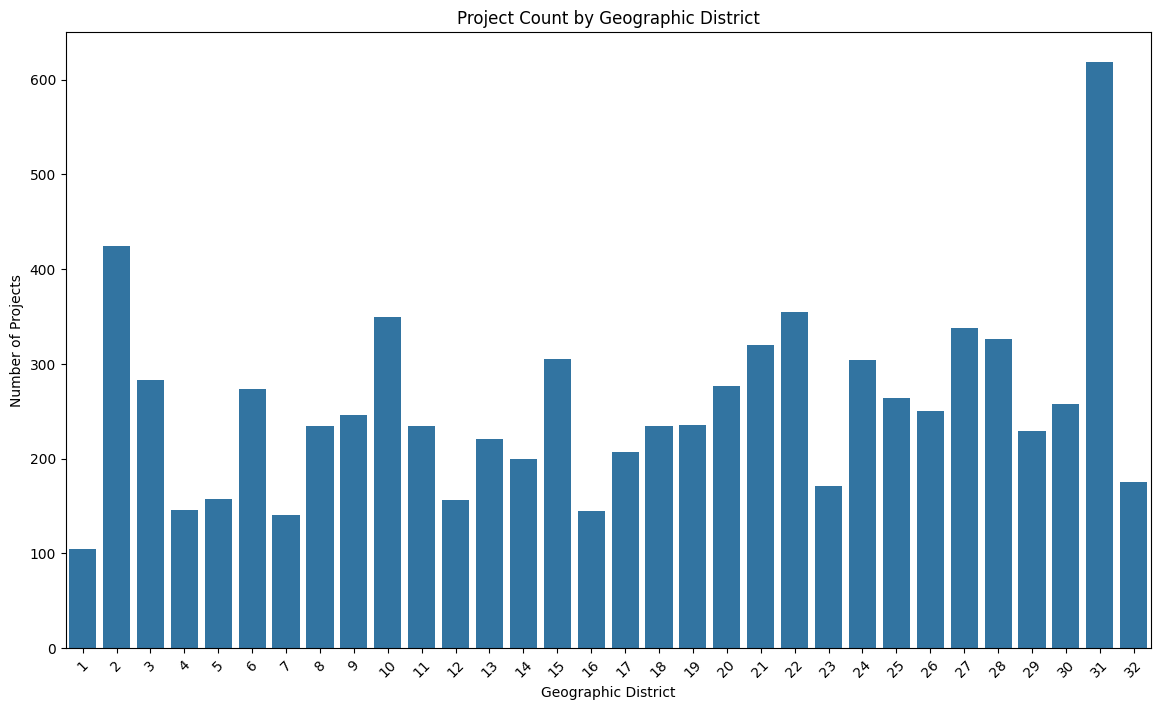

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df_cleaned, x='project_geographic_district')
plt.title('Project Count by Geographic District')
plt.xlabel('Geographic District')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.show()

#### Project Status Distribution


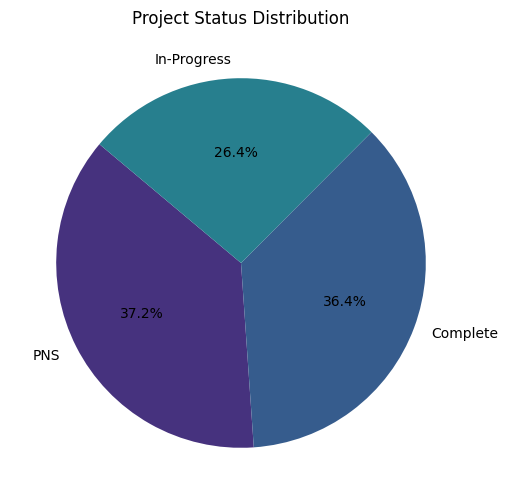

In [ ]:
plt.figure(figsize=(10, 6))
project_status_counts = df_cleaned['project_status_name'].value_counts()
plt.pie(project_status_counts, labels=project_status_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Project Status Distribution')
plt.show()

#### Total Spending by Project Type


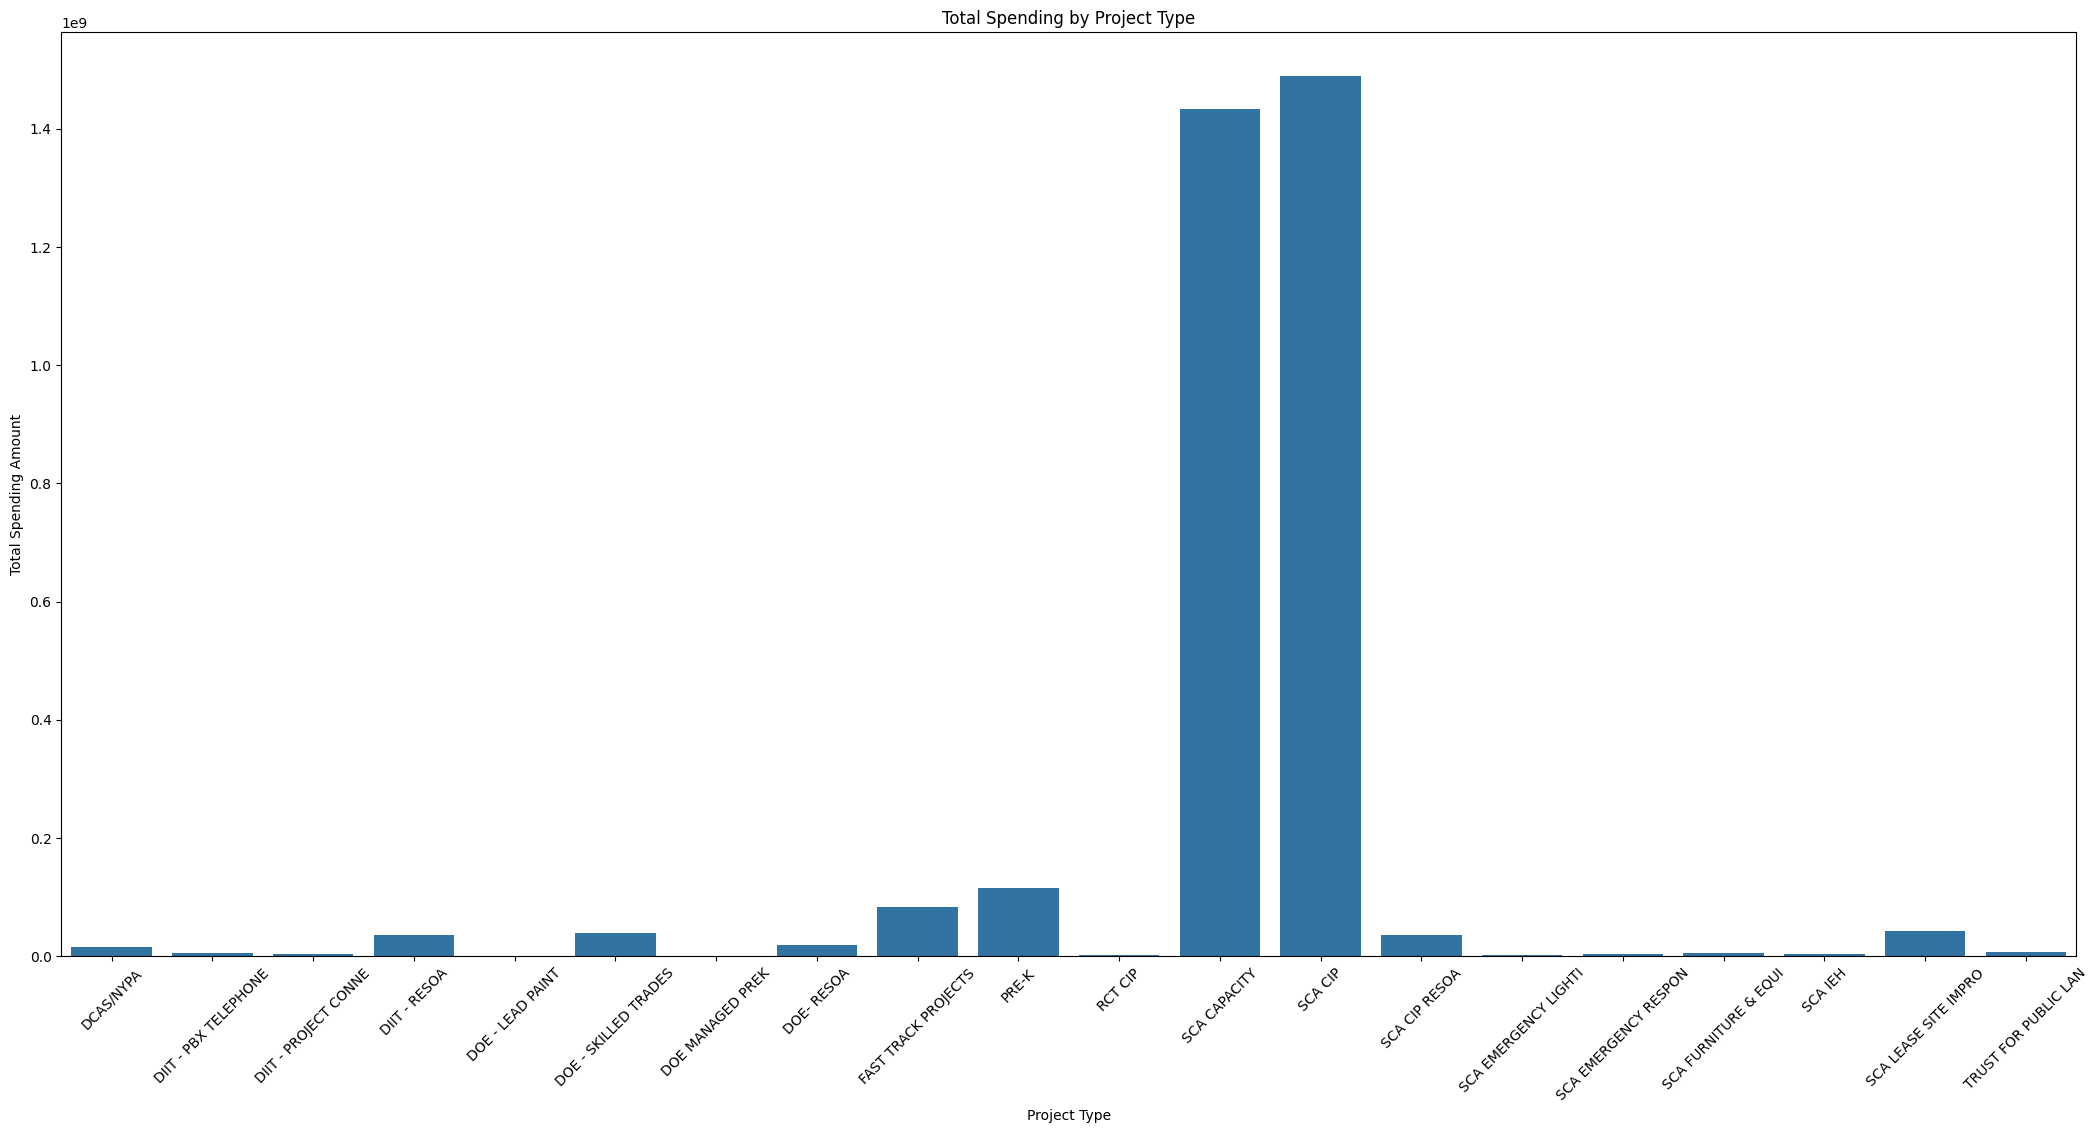

In [ ]:
plt.figure(figsize=(26, 12))
total_spending_by_type = df_cleaned.groupby('project_type')['total_phase_actual_spending_amount'].sum().reset_index()
sns.barplot(data=total_spending_by_type, x='project_type', y='total_phase_actual_spending_amount')
plt.title('Total Spending by Project Type')
plt.xlabel('Project Type')
plt.ylabel('Total Spending Amount')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Creating new columns for year of start and end dates
df_cleaned['start_year'] = df_cleaned['project_phase_actual_start_date'].dt.year
df_cleaned['end_year'] = df_cleaned['project_phase_actual_end_date'].dt.year

# Calculating project duration in days
df_cleaned['project_duration_days'] = (df_cleaned['project_phase_actual_end_date'] - df_cleaned['project_phase_actual_start_date']).dt.days

# Display the new columns to verify the transformation
df_cleaned[['project_phase_actual_start_date', 'project_phase_actual_end_date', 'start_year', 'end_year', 'project_duration_days']].head()

,project_phase_actual_start_date,project_phase_actual_end_date,start_year,end_year,project_duration_days
0,2016-07-07,NaT,2016.0,NaN,NaN
1,2016-07-07,NaT,2016.0,NaN,NaN
2,2017-07-27,2017-08-03,2017.0,2017.0,7.0
3,2017-08-04,NaT,2017.0,NaN,NaN
4,NaT,NaT,NaN,NaN,NaN


#### More analysis

Total Budget and Spending by Geographic District: Aggregate budget and spending data by geographic district.

Average Project Duration by Project Type: Calculate the average duration of projects by project type.

<Figure size 2000x800 with 0 Axes>

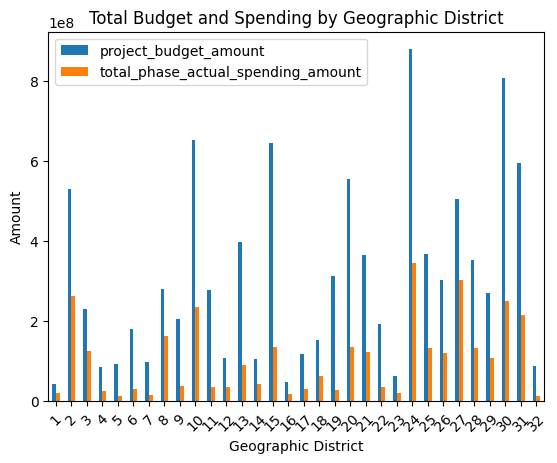

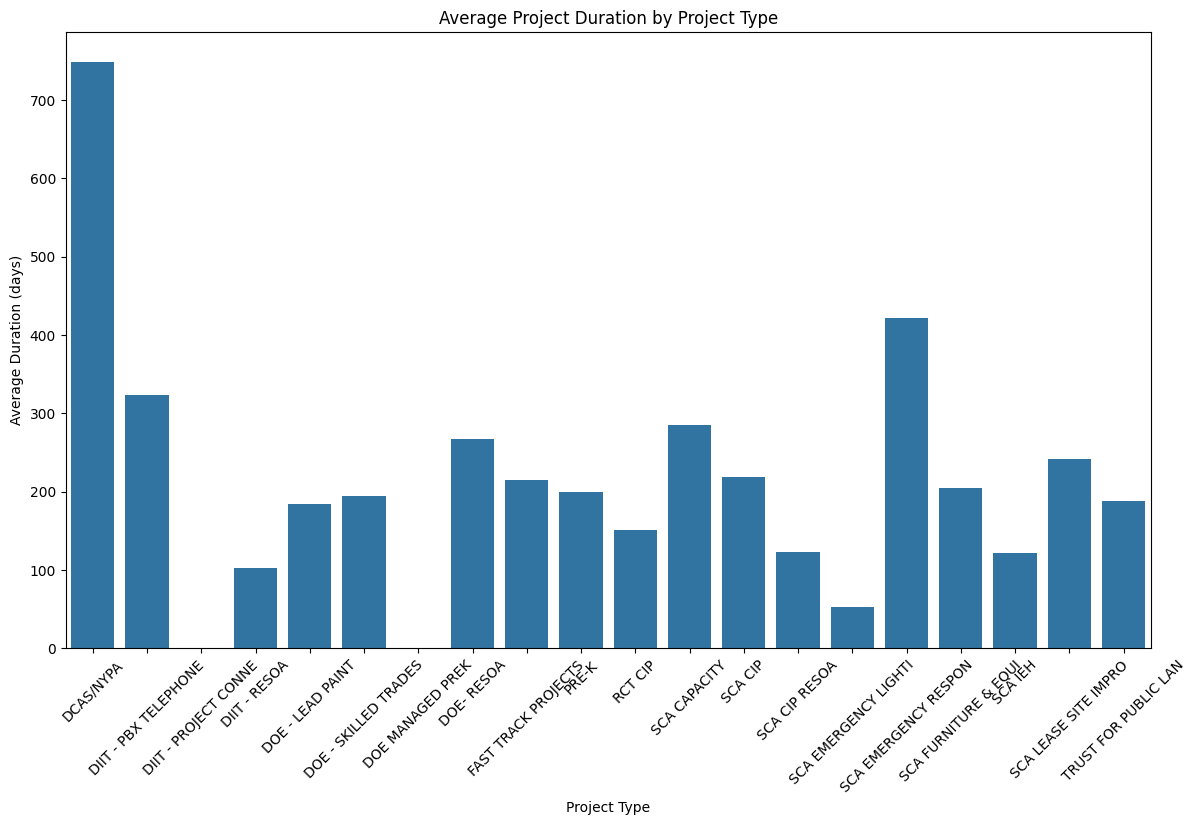

In [ ]:
# Aggregating total budget and spending by geographic district
total_budget_spending_by_district = df_cleaned.groupby('project_geographic_district')[['project_budget_amount', 'total_phase_actual_spending_amount']].sum()

# Calculating average project duration by project type
average_duration_by_project_type = df_cleaned.groupby('project_type')['project_duration_days'].mean().reset_index()

# Total Budget and Spending by Geographic District
plt.figure(figsize=(20, 8))
total_budget_spending_by_district.plot(kind='bar', stacked=False)
plt.title('Total Budget and Spending by Geographic District')
plt.xlabel('Geographic District')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

# Average Project Duration by Project Type
plt.figure(figsize=(14, 8))
sns.barplot(data=average_duration_by_project_type, x='project_type', y='project_duration_days')
plt.title('Average Project Duration by Project Type')
plt.xlabel('Project Type')
plt.ylabel('Average Duration (days)')
plt.xticks(rotation=45)
plt.show()

#### Feature engineering

In [ ]:
df_cleaned['project_phase_actual_duration'] = (pd.to_datetime(df_cleaned['project_phase_actual_end_date']) - pd.to_datetime(df_cleaned['project_phase_actual_start_date'])).dt.days
df_cleaned['project_phase_planned_duration'] = (pd.to_datetime(df_cleaned['project_phase_planned_end_date']) - pd.to_datetime(df_cleaned['project_phase_actual_start_date'])).dt.days

In [ ]:
phase_count = df_cleaned.groupby('project_building_identifier')['project_phase_name'].nunique().reset_index()
phase_count.columns = ['project_building_identifier', 'number_of_phases']
df_cleaned = df_cleaned.merge(phase_count, on='project_building_identifier', how='left')

In [ ]:
df_filtered = df_cleaned[[
    'project_type',
    'project_phase_actual_end_date', # Keeping this column because some project types appear in it which is wack
    'project_description',
    'project_phase_name',
    'project_status_name',
    'dsf_number_s',
    'failure'
]]

df_filtered.to_csv('ibm_filtered.csv', index=False)

In [ ]:
# Same DSF number = same project
failure_sums = df_filtered[['project_type', 'failure']].groupby('project_type').sum()
failure_sums

,failure
project_type,
DCAS/NYPA,0
DIIT - PBX TELEPHONE,6
DIIT - PROJECT CONNE,180
DIIT - RESOA,65
DOE - LEAD PAINT,29
DOE - SKILLED TRADES,33
DOE MANAGED PREK,0
DOE- RESOA,17
FAST TRACK PROJECTS,2


In [ ]:
# Total number of projects per project type
total_projects = df_filtered.groupby('project_type').size()

# Total number of failures per project type
total_failures = df_filtered.groupby('project_type')['failure'].sum()

# Calculate the failure rate per project type
failure_rate = total_failures / total_projects

# Convert to DataFrame for better readability
failure_rate_df = failure_rate.reset_index(name='failure_rate')
failure_rate_df

,project_type,failure_rate
0,DCAS/NYPA,0.000000
1,DIIT - PBX TELEPHONE,0.214286
2,DIIT - PROJECT CONNE,0.923077
3,DIIT - RESOA,0.137421
4,DOE - LEAD PAINT,0.256637
5,DOE - SKILLED TRADES,0.097345
6,DOE MANAGED PREK,0.000000
7,DOE- RESOA,0.067460
8,FAST TRACK PROJECTS,0.033333
9,PRE-K,0.160714


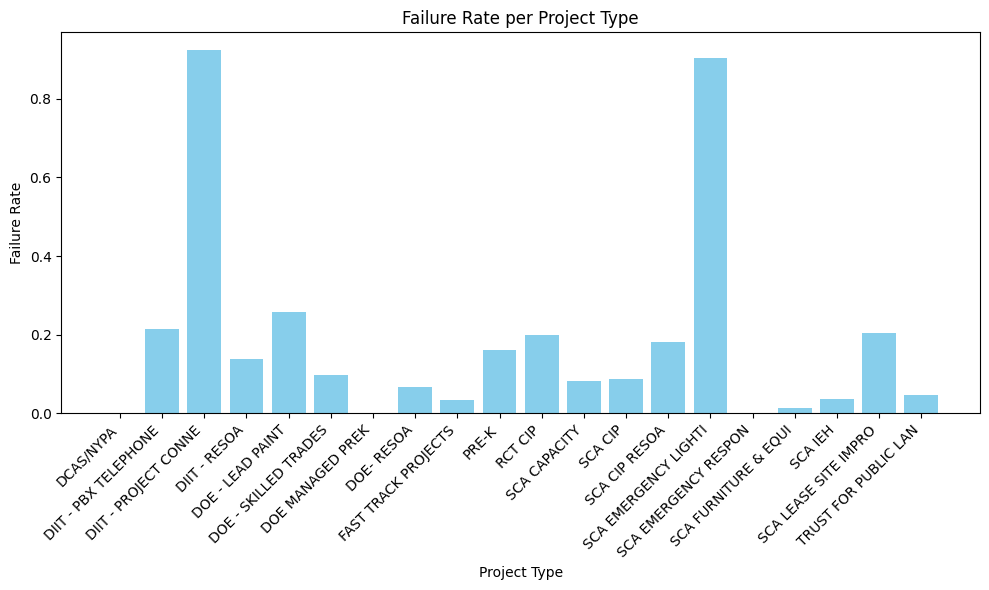

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(failure_rate_df['project_type'], failure_rate_df['failure_rate'], color='skyblue')
plt.xlabel('Project Type')
plt.ylabel('Failure Rate')
plt.title('Failure Rate per Project Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# # Split the DSF numbers and explode into separate rows
# df['dsf_number_s'] = df['dsf_number_s'].str.replace('DSF: ', '')
# df['dsf_number_s'] = df['dsf_number_s'].str.split(', ')
# df = df.explode('dsf_number_s')

# df.reset_index(drop=True, inplace=True)
# df

In [ ]:
# correlation_matrix = df[df.select_dtypes(include=[np.number]).columns].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

In [ ]:
# # Set the style of the visualization
# sns.set(style="whitegrid")

# # Create the boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(y=df['project_budget_amount'])

# # Add title and labels
# plt.title('Boxplot of Values')
# plt.ylabel('Values')

# # Show the plot
# plt.show()
